<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/autoencoder_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras.datasets import mnist,cifar10
import numpy as np
import requests
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

# data
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 3072)
(10000, 3072)


In [2]:
# model
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from sklearn.neighbors import NearestNeighbors

class autoencoder_knn(object):
  def __init__(self,input_dim=100,encoding_dim=32,n_layer=3,n_neighbors=1,algorithm='ball_tree'):
    self.knn = NearestNeighbors(n_neighbors=n_neighbors,algorithm=algorithm)
    self.autoencoder,self.encoder = self.build_autoencoder(input_dim,encoding_dim,n_layer)
    print(self.autoencoder.summary())

  def mlp(self,x,sizes,activation=tf.tanh,output_activation=None):
    for size in sizes[:-1]:
      x = layers.Dense(units=size,activation=activation)(x)
    return layers.Dense(units=sizes[-1],activation=output_activation)(x) 
  
  def build_autoencoder(self,input_dim,encoding_dim,n_layer):
    # 根據encoding_dim,input_dim,n_layer調整神經網路架構
    sizes = [int(i) for i in np.linspace(encoding_dim,input_dim,n_layer)]
    input = keras.Input(shape=(input_dim,))#輸入
    encoded = self.mlp(x=input,sizes=sizes[::-1][1:])#編碼
    decoded = self.mlp(x=encoded,sizes=sizes[1:])#解碼
    autoencoder = keras.Model(input,decoded,name='autoencoder')#自編碼模型
    autoencoder.compile(optimizer='adam',loss='mean_squared_error')#編譯
    encoder = keras.Model(input,encoded)#編碼器模型
    return autoencoder,encoder
  
  def train(self,x,epochs=10,batch_size=256):
    # 訓練完自編碼器將簡化特徵拿去訓練knn
    self.autoencoder.fit(x,x,epochs=epochs,batch_size=batch_size,shuffle=True)
    features = self.encoder.predict(x)
    self.knn.fit(features)

  def predict(self,x):
    #對輸入樣本抽取簡化特徵然後丟給knn
    features = self.encoder.predict(x)
    _ ,idx = self.knn.kneighbors(features)
    return idx


In [3]:
# train
model = autoencoder_knn(input_dim=x_train.shape[1],encoding_dim=32)
model.train(x_train)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 1552)              4769296   
                                                                 
 dense_1 (Dense)             (None, 32)                49696     
                                                                 
 dense_2 (Dense)             (None, 1552)              51216     
                                                                 
 dense_3 (Dense)             (None, 3072)              4770816   
                                                                 
Total params: 9,641,024
Trainable params: 9,641,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 [====================

No handles with labels found to put in legend.


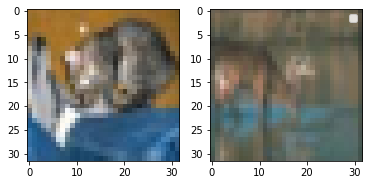

No handles with labels found to put in legend.


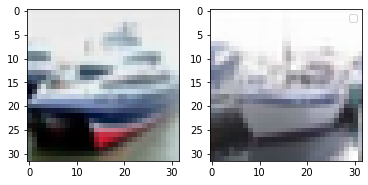

No handles with labels found to put in legend.


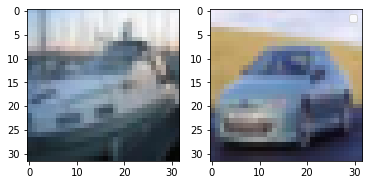

No handles with labels found to put in legend.


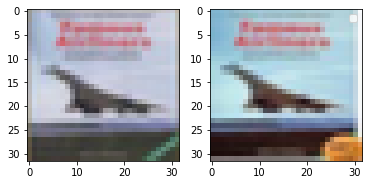

No handles with labels found to put in legend.


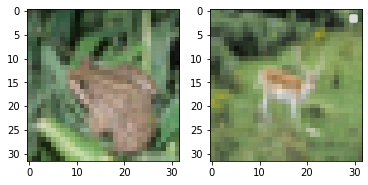

No handles with labels found to put in legend.


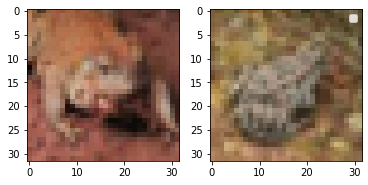

No handles with labels found to put in legend.


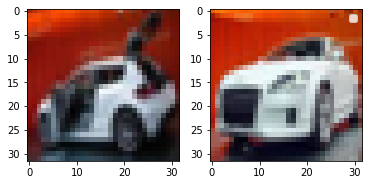

No handles with labels found to put in legend.


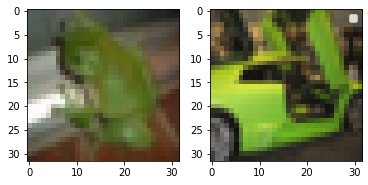

No handles with labels found to put in legend.


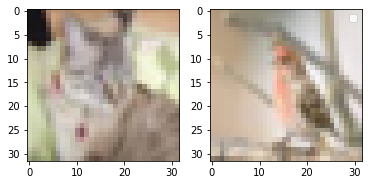

No handles with labels found to put in legend.


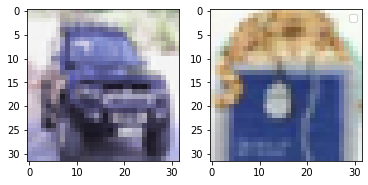

In [4]:
import matplotlib.pyplot as plt
n = 10
y_pred = model.predict(x_test[:n].reshape(n,-1))

for i in range(n):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.subplot(1,2,2)
  plt.imshow(x_train[y_pred[i][0]].reshape(32,32,3))
  plt.legend()
  plt.show()